# REST API

In [5]:
import requests
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

When I analyze the data I find that the motivation can be found as a key called 'motivation'. That key contains a dict with two keys, one called 'en' for english and one called 'se' for swedish, so I will use the 'en' for now. I also find the the 'motivation' is the same to all nobel winners each year, so I will only save the motivation once per year. I also make a loop that goes thru all years from 1901 to 2023. I use a dict called nltk (Natural Language Toolkit) to identify stopwords and that I dont add them to the list of words. I then create a wordcloud and plot it.

In [6]:
# Download the stopwords corpus (only need to do this once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
STOP_WORDS = set(stopwords.words('english'))

# Function to recursively find the first 'motivation' field and filter stop words
def find_first_motivation_words(obj, words, found):
    if found[0]:  # If already found, stop processing
        return
    if isinstance(obj, dict):
        for key, value in obj.items():
            if key == "motivation" and not found[0]:
                # Check if the value is a dictionary with an 'en' key
                if isinstance(value, dict) and "en" in value:
                    # Extract words from the English motivation text
                    raw_words = re.findall(r'\b\w+\b', value["en"])
                    # Filter out stop words
                    words.extend(word for word in raw_words if word.lower() not in STOP_WORDS)
                    found[0] = True  # Mark as found
                return
            else:
                find_first_motivation_words(value, words, found)
    elif isinstance(obj, list):
        for item in obj:
            find_first_motivation_words(item, words, found)

# Loop through years from 1901 to 2023
all_motivation_words = []
for year in range(1901, 2024):
    # print(f"Processing year {year}...")
    URI = f"http://api.nobelprize.org/2.1/nobelPrize/phy/{year}"
    response = requests.get(URI)
    if response.status_code == 200:
        data = response.json()
        motivation_words = []
        found = [False]  # Flag to track if the first motivation is found
        find_first_motivation_words(data, motivation_words, found)
        all_motivation_words.extend(motivation_words)
    else:
        print(f"Failed to fetch data for year {year}. Status code: {response.status_code}")

# Print all collected non-stop words from motivations
# print(all_motivation_words)

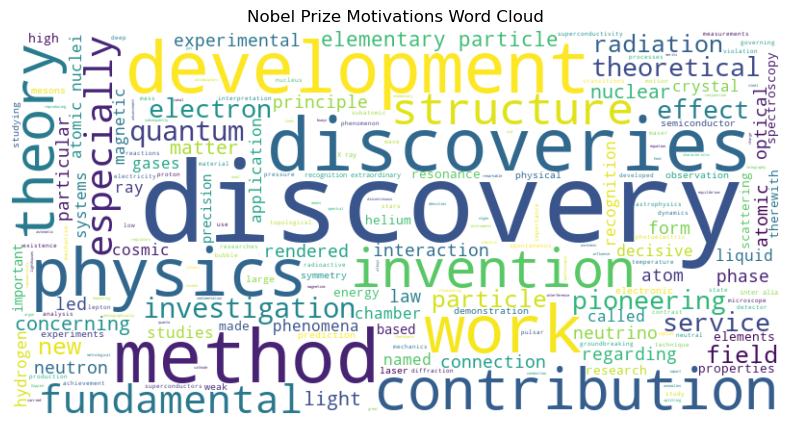

In [8]:
# Generate a single string of words from the list
word_string = ' '.join(all_motivation_words)

# Create the WordCloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(word_string)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title("Nobel Prize Motivations Word Cloud")
plt.show()

I then do the same thing but with the swedish translations

In [9]:
# Get Swedish stopwords from nltk
SWEDISH_STOP_WORDS = set(stopwords.words('swedish'))

def find_first_motivation_words_se(obj, words, found):
    if found[0]:  # If already found, stop processing
        return
    if isinstance(obj, dict):
        for key, value in obj.items():
            if key == "motivation" and not found[0]:
                # Check if the value is a dictionary with a 'se' key
                if isinstance(value, dict) and "se" in value:
                    # Extract words from the Swedish motivation text
                    raw_words = re.findall(r'\b\w+\b', value["se"])
                    # Filter out Swedish stop words
                    words.extend(word for word in raw_words if word.lower() not in SWEDISH_STOP_WORDS)
                    found[0] = True  # Mark as found
                return
            else:
                find_first_motivation_words_se(value, words, found)
    elif isinstance(obj, list):
        for item in obj:
            find_first_motivation_words_se(item, words, found)

all_motivation_words_se = []
for year in range(1901, 2024):
    # print(f"Processing year {year} for Swedish motivations...") 
    URI = f"http://api.nobelprize.org/2.1/nobelPrize/phy/{year}"
    response = requests.get(URI)
    if response.status_code == 200:
        data = response.json()
        motivation_words = []
        found = [False]  # Flag to track if the first motivation is found
        find_first_motivation_words_se(data, motivation_words, found)
        all_motivation_words_se.extend(motivation_words)
    else:
        print(f"Failed to fetch data for year {year}. Status code: {response.status_code}")

# Print Swedish words
# print(all_motivation_words_se)

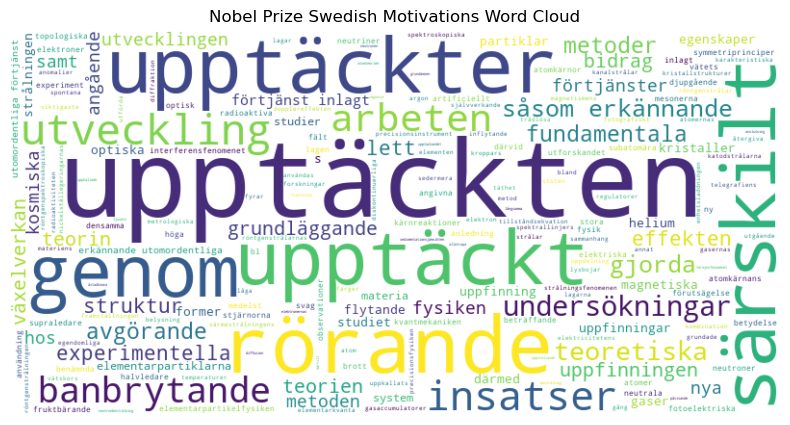

In [10]:
# Generate a word cloud for Swedish words
word_string_se = ' '.join(all_motivation_words_se)

wordcloud_se = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(word_string_se)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_se, interpolation='bilinear')
plt.axis('off')
plt.title("Nobel Prize Swedish Motivations Word Cloud")
plt.show()

# Web Scraping

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL of the website
base_url = "https://books.toscrape.com/"

# Make a GET request to fetch the raw HTML content of the main page
response = requests.get(base_url)
html_content = response.text

# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Find all book containers on the main page
book_containers = soup.find_all("article", class_="product_pod")

# List to store scraped data
books_data = []

# Loop through each book container and extract the required data
for book in book_containers:
    # Extract the relative link to the book's detail page
    book_link = book.find("h3").find("a")["href"]
    
    # Form the full URL by appending the relative link to the base URL
    detail_url = base_url + book_link.strip(".")

    # Visit the book detail page to extract the UPC
    detail_response = requests.get(detail_url)
    detail_soup = BeautifulSoup(detail_response.text, "html.parser")
    
    # Extract UPC from the detail page
    upc = "Not found"  # Default value if UPC is not found
    
    # Find the table with product details on the detail page
    table = detail_soup.find("table", class_="table table-striped")
    
    # If the table is found, look for the UPC row
    if table:
        rows = table.find_all("tr")
        for row in rows:
            th = row.find("th")
            if th and th.text.strip() == "UPC":
                td = row.find("td")
                if td:
                    upc = td.text.strip()  # Extract the UPC value

    # Extract other details from the main page
    title = book.find("h3").find("a")["title"]  # Book title
    if price.startswith("Â"):  # Check if the first character is the unwanted one
        price = price[1:]  # Remove Â
    rating = book.find("p", class_="star-rating")["class"][1]  # Book rating (e.g., "One", "Two", etc.)

    # Store the data in the list
    books_data.append({
        "upc": upc, 
        "title": title,
        "price": price,
        "rating": rating
    })

# Create a pandas DataFrame from the books_data list
df = pd.DataFrame(books_data)

df


,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£45.22,Three
1,90fa61229261140a,Tipping the Velvet,£45.22,One
2,6957f44c3847a760,Soumission,£45.22,One
3,e00eb4fd7b871a48,Sharp Objects,£45.22,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£45.22,Five
5,f77dbf2323deb740,The Requiem Red,£45.22,One
6,2597b5a345f45e1b,The Dirty Little Secrets of Getting Your Dream...,£45.22,Four
7,e72a5dfc7e9267b2,The Coming Woman: A Novel Based on the Life of...,£45.22,Three
8,e10e1e165dc8be4a,The Boys in the Boat: Nine Americans and Their...,£45.22,Four
9,1dfe412b8ac00530,The Black Maria,£45.22,One


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL of the website
base_url = "https://books.toscrape.com/catalogue/"

# List to store scraped data
books_data = []

# Loop through the first 3 pages
for page in range(1, 4):  # Pages 1 to 3
    # Construct the URL for each page
    page_url = f"https://books.toscrape.com/catalogue/page-{page}.html"
    
    # Make a GET request to fetch the raw HTML content of the page
    response = requests.get(page_url)
    html_content = response.text

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, "html.parser")

    # Find all book containers on the page
    book_containers = soup.find_all("article", class_="product_pod")

    # Loop through each book container and extract the required data
    for book in book_containers:
        # Extract the relative link to the book's detail page
        book_link = book.find("h3").find("a")["href"]
        
        # Form the full URL by appending the relative link to the base URL
        detail_url = base_url + book_link.strip(".")

        # Visit the book detail page to extract the UPC
        detail_response = requests.get(detail_url)
        detail_soup = BeautifulSoup(detail_response.text, "html.parser")
        
        # Extract UPC from the detail page
        upc = "Not found"  # Default value if UPC is not found
        
        # Find the table with product details on the detail page
        table = detail_soup.find("table", class_="table table-striped")
        
        # If the table is found, look for the UPC row
        if table:
            rows = table.find_all("tr")
            for row in rows:
                th = row.find("th")
                if th and th.text.strip() == "UPC":
                    td = row.find("td")
                    if td:
                        upc = td.text.strip()  # Extract the UPC value

        # Extract other details from the main page
        title = book.find("h3").find("a")["title"]  # Book title
        price = book.find("p", class_="price_color").text.strip()  # Book price
        if price.startswith("Â"):  # Check if the first character is the unwanted one
            price = price[1:]  # Remove Â
        rating = book.find("p", class_="star-rating")["class"][1]  # Book rating (e.g., "One", "Two", etc.)

        # Store the data in the list
        books_data.append({
            "upc": upc, 
            "title": title,
            "price": price,
            "rating": rating
        })

# Create a pandas DataFrame from the books_data list
df = pd.DataFrame(books_data)

# Display the dataframe
df
